### Synthetic signals : Estimation of the variance from the autocovariance

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [59]:
#Load data
path = '/Users/zcaspar/codes/mit4320/' 
#ds1 = xr.open_dataset(path+'synthetic_1_U.nc') #one draw
#ds30 = xr.open_dataset(path+'synthetic_30_U.nc') #30 draws

#ds1_80 = xr.open_dataset(path+'synthetic_1_U_80d.nc') #one draw
#ds30_80 = xr.open_dataset(path+'synthetic_30_U_80d.nc') #30 draws

ds1 = xr.open_dataset(path+'synthetic_1_U.nc') #one draw
ds30 = xr.open_dataset(path+'synthetic_30_U_valid.nc') #30 draws

ds30_coh = xr.open_dataset(path+'synthetic_30_valid.nc') #30 draws
#ds1_80 = xr.open_dataset(path+'synthetic_1_U_80d.nc') #one draw
ds30_80 = xr.open_dataset(path+'synthetic_30_U_valid_80.nc') #30 draws

time = ds1.tau.values
time_80 = ds30_80.tau.values
print(time)

[0.00000000e+00 4.16666667e-02 8.33333333e-02 ... 4.99875000e+02
 4.99916667e+02 4.99958333e+02]


In [60]:
ds30 = ds30.assign_coords({'bandwidth':[d*2 for d in ds30.bandwidth]})

In [61]:
ds30 = ds30.sel(T=[5,15,30,80])
ds30_80 = ds30_80.sel(T=[5,15,30,80])
ds1 = ds1.sel(T=[5,15,30,80])

#### Monochromatic signal

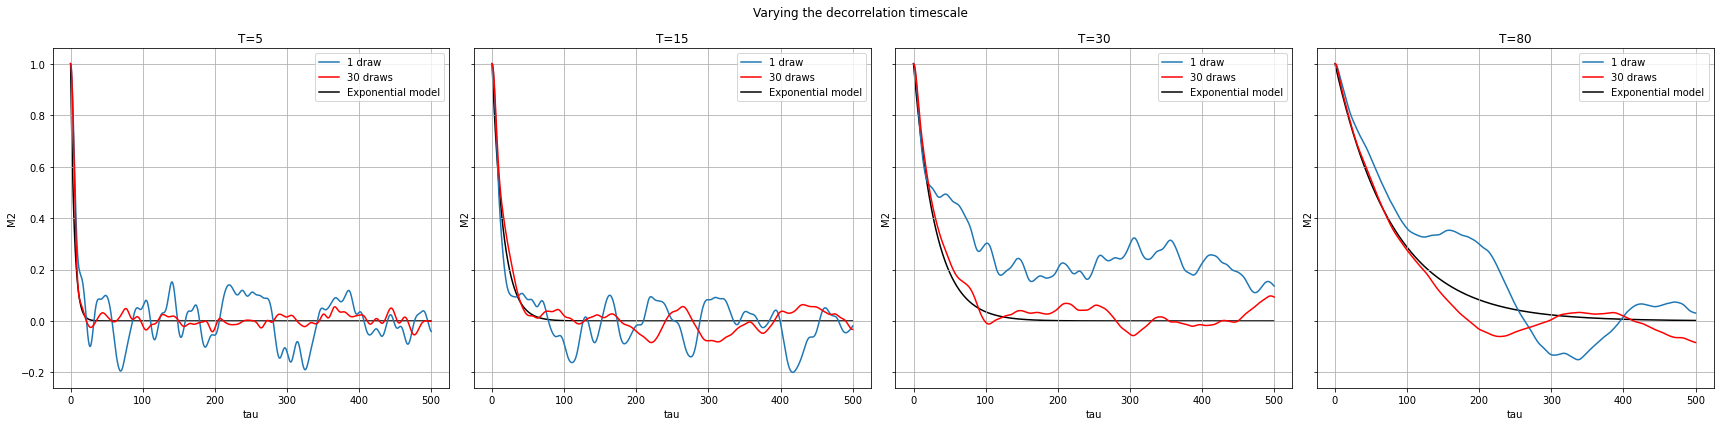

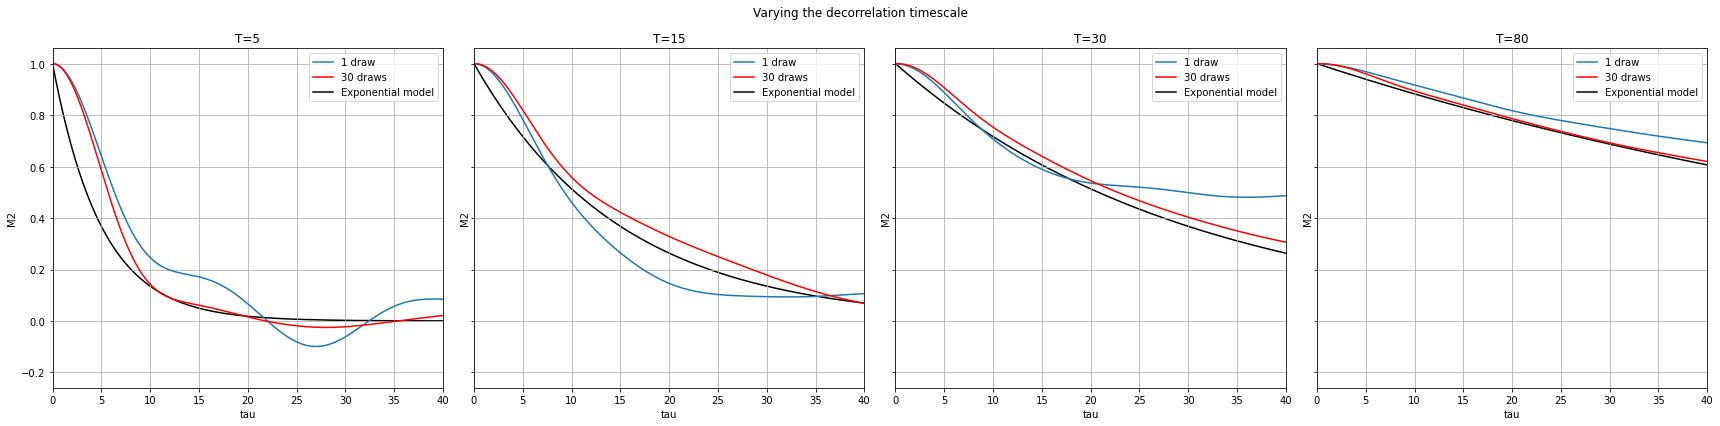

In [62]:
fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw')
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
                                     ).plot(ax=ax[i],label='30 draws',c='r')
    ax[i].plot(time,np.exp(-time/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timescale');
fig.tight_layout();

fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
for i,t in enumerate(ds1.T):
    (ds1.high_M2/ds1.high_M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t).plot(ax=ax[i],label='1 draw',xlim=(0,40))
    (ds30.M2/ds30.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
                                     ).plot(ax=ax[i],label='30 draws',c='r',xlim=(0,40))
    ax[i].plot(time_80,np.exp(-time_80/t.values),c='k',zorder=0,label='Exponential model')
    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
fig.suptitle('Varying the decorrelation timescale');
fig.tight_layout();

#fig,ax = plt.subplots(1,ds1.T.size,figsize=(6*(ds1.T.size),6),sharey=True)
#for i,t in enumerate(ds1.T):
#   (ds30_80.M2/ds30_80.M2.isel(tau=0)).sel(bandwidth=0.2,Tw=30,U_high=0.1,T=t,T_low=30
#                                 ).plot(ax=ax[i],label='30 draws',c='r')
    #ax[i].plot(time_80,np.exp(-time_80/t.values),c='k',zorder=0,label='Exponential model')
#    ax[i].set_title('T=%s'%t.values);ax[i].grid();ax[i].legend()
#fig.suptitle('Varying the decorrelation timescale');
#fig.tight_layout();

In [63]:
Var = ds30.sel(tau=0)
Var_80 = ds30_80.sel(tau=0)
Var

<xarray.Dataset>
Dimensions:    (T: 4, T_low: 3, Tw: 3, U_high: 4, bandwidth: 4)
Coordinates:
  * T          (T) int64 5 15 30 80
  * U_high     (U_high) float64 0.01 0.05 0.1 1.0
  * T_low      (T_low) int64 5 30 100
  * Tw         (Tw) int64 15 30 60
  * bandwidth  (bandwidth) float64 0.1 0.2 0.4 0.6
    tau        float64 0.0
Data variables:
    M2         (Tw, bandwidth, T, U_high, T_low) float64 ...
    S2         (Tw, bandwidth, T, U_high, T_low) float64 ...
    high_MS    (Tw, bandwidth, T, U_high, T_low) float64 ...
    total      (Tw, bandwidth, T, U_high, T_low) float64 ...

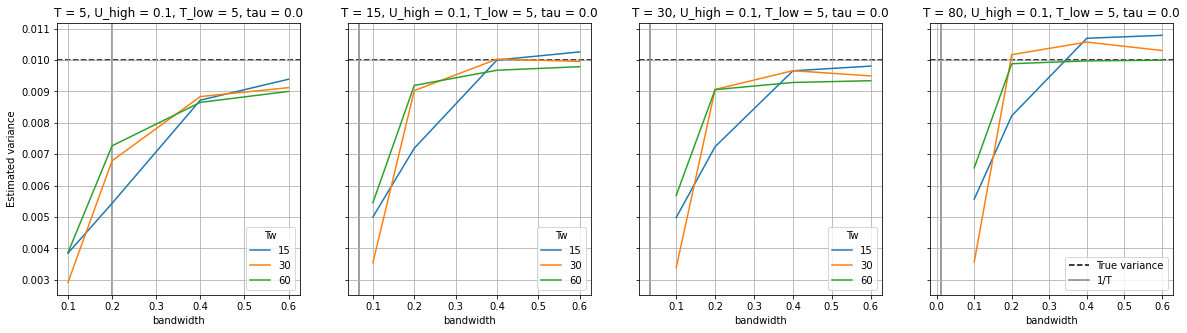

In [66]:
fig,ax = plt.subplots(1,Var.T.size,figsize=(5*Var.T.size,5),sharey=True)
for i,t in enumerate(Var.T):
    Var.sel(T_low=5,U_high=0.1,T=t).high_MS.plot(hue='Tw',ax=ax[i],add_legend=True)
    ax[i].grid();ax[i].axhline(0.01,c='k',linestyle='--',zorder=0,label='True variance')
    ax[i].set_ylabel('');ax[i].axvline(1/t,c='grey',zorder=0,label='1/T')
ax[0].set_ylabel('Estimated variance')
ax[-1].legend();

Text(0, 0.5, 'Estimated variance')

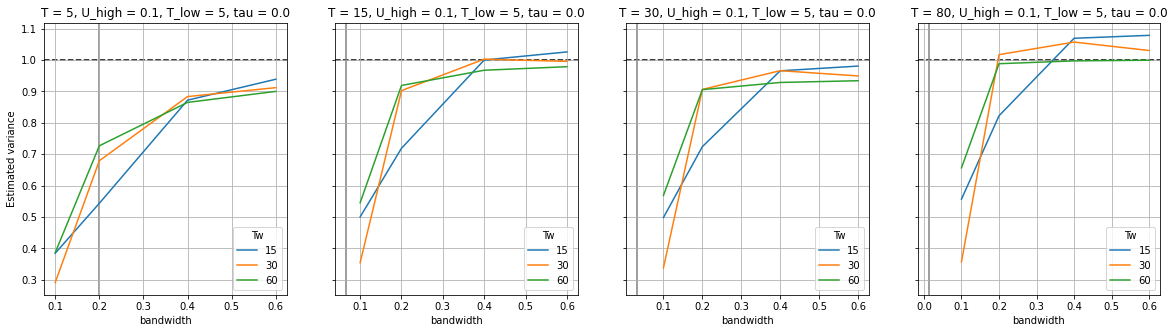

In [76]:
fig,ax = plt.subplots(1,Var.T.size,figsize=(5*Var.T.size,5),sharey=True)
for i,t in enumerate(Var.T):
    (Var.sel(T_low=5,U_high=0.1,T=t).high_MS/0.01).plot(hue='Tw',ax=ax[i],add_legend=True)
    ax[i].grid();ax[i].axhline(1,c='k',linestyle='--',zorder=0,label='True variance')
    ax[i].set_ylabel('');ax[i].axvline(1/t,c='grey',zorder=0,label='1/T')
ax[0].set_ylabel('Estimated variance')

<Figure size 432x288 with 0 Axes>

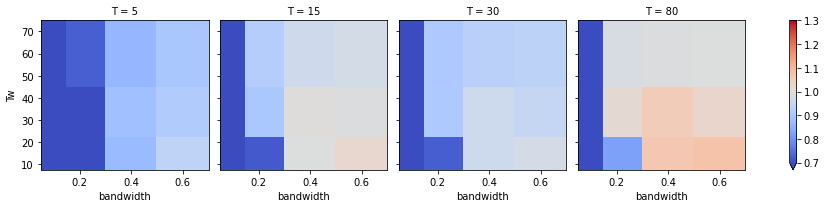

<Figure size 432x288 with 0 Axes>

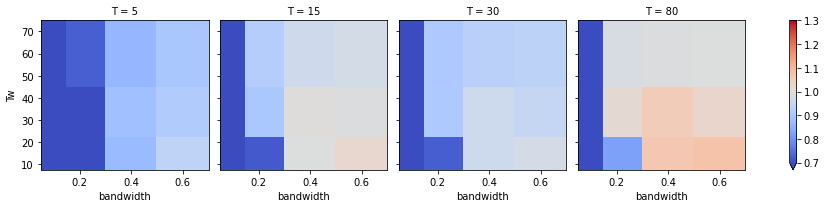

<Figure size 432x288 with 0 Axes>

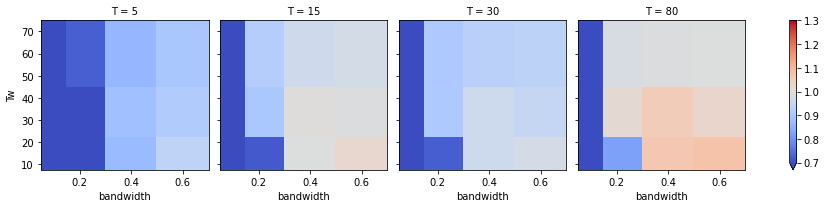

<Figure size 432x288 with 0 Axes>

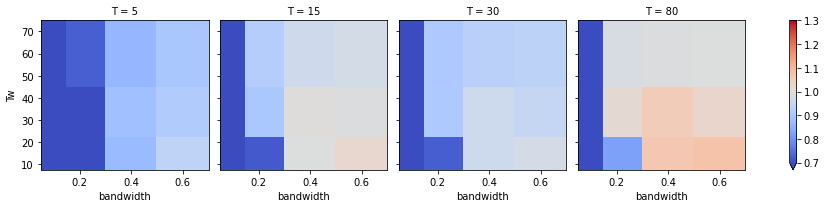

In [90]:
for U in Var.U_high:
    plt.figure()
    (Var.sel(T_low=5,U_high=U).high_MS/(U**2)).plot(col='T',cmap='coolwarm',vmax=1.3,vmin=0.7)

Pas de changements selon $\tilde V^2$

$d\omega = 0.1$cpd échoue systématiquement même pour $1/\tilde T \ll 0.1$

En général, plus la largeur de bande est grande, plus la variance estimée est proche de la 'vraie' variance

$T_w$ a une légère influence, pour T=80jours Tw<60, surestime la variance

#### Signal total

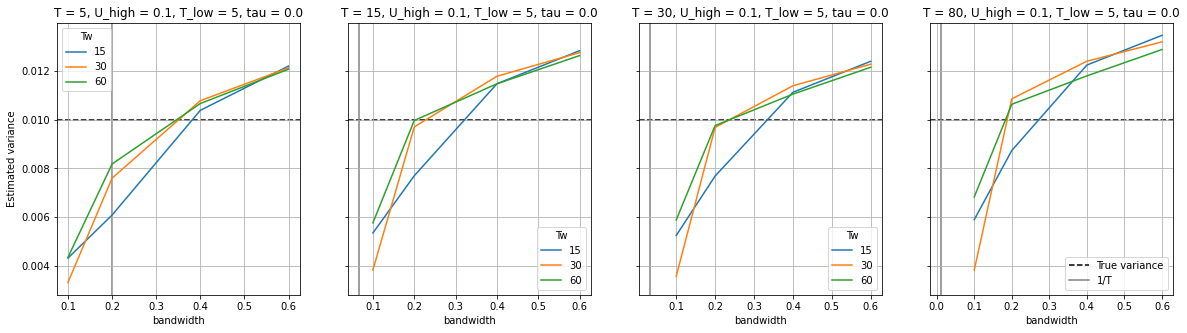

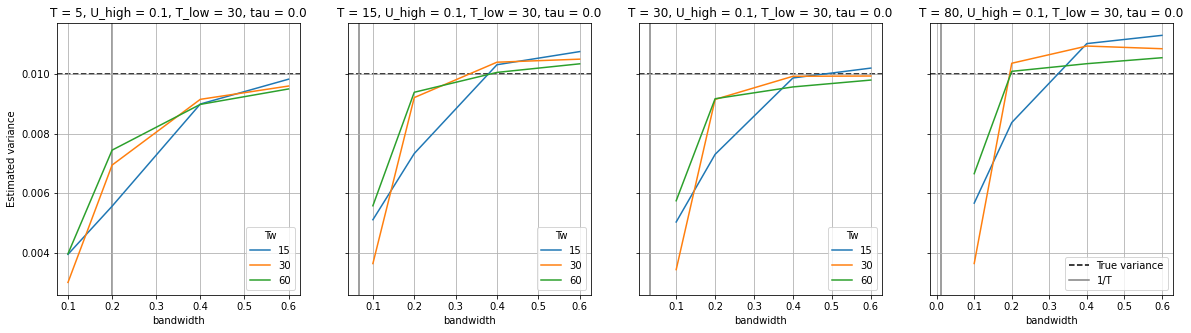

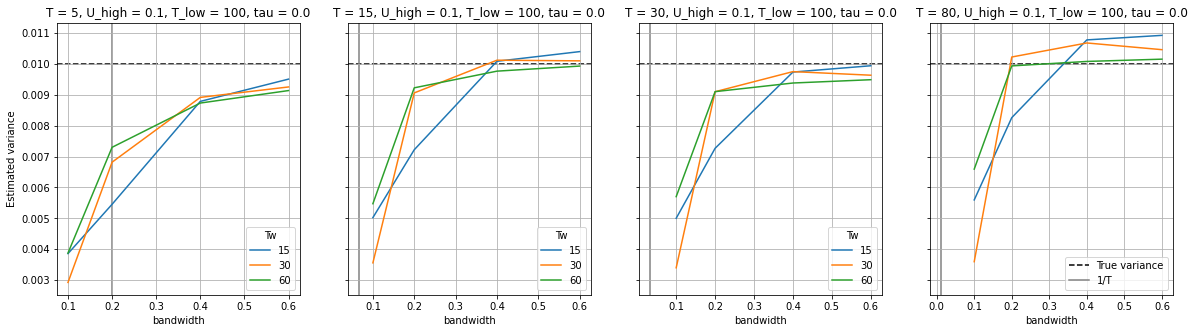

In [91]:
for tl in Var.T_low:
    fig,ax = plt.subplots(1,Var.T.size,figsize=(5*Var.T.size,5),sharey=True)
    for i,t in enumerate(Var.T):
        Var.sel(T_low=tl,U_high=0.1,T=t).total.plot(hue='Tw',ax=ax[i],add_legend=True)
        ax[i].grid();ax[i].axhline(0.01,c='k',linestyle='--',zorder=0,label='True variance')
        ax[i].set_ylabel('');ax[i].axvline(1/t,c='grey',zorder=0,label='1/T')
    ax[0].set_ylabel('Estimated variance')
    ax[-1].legend();

<Figure size 432x288 with 0 Axes>

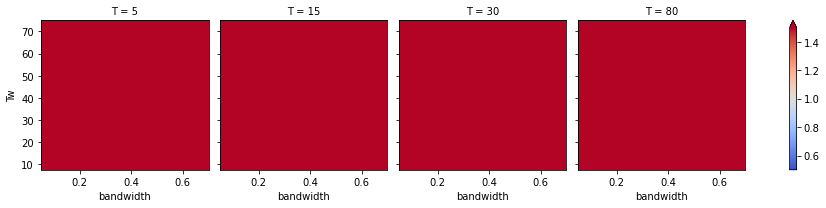

<Figure size 432x288 with 0 Axes>

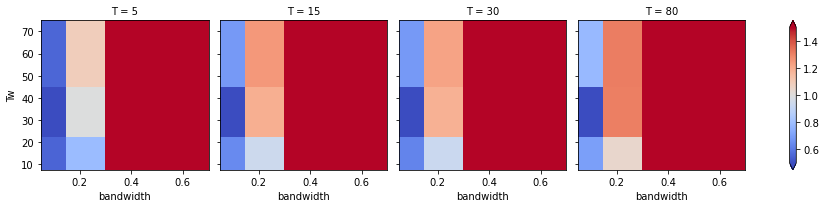

<Figure size 432x288 with 0 Axes>

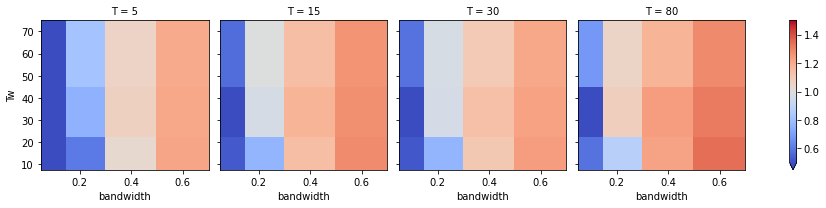

<Figure size 432x288 with 0 Axes>

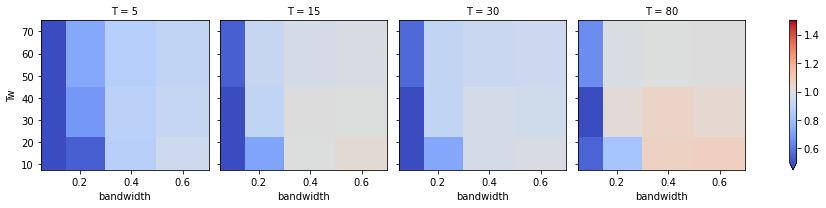

In [95]:
for U in Var.U_high:
    plt.figure()
    (Var.sel(T_low=5,U_high=U).total/(U**2)).plot(col='T',cmap='coolwarm',vmax=1.5,vmin=0.5)

<Figure size 432x288 with 0 Axes>

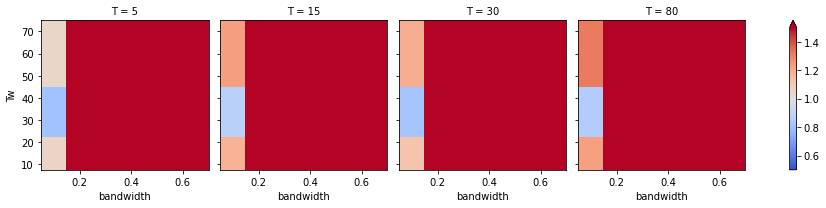

<Figure size 432x288 with 0 Axes>

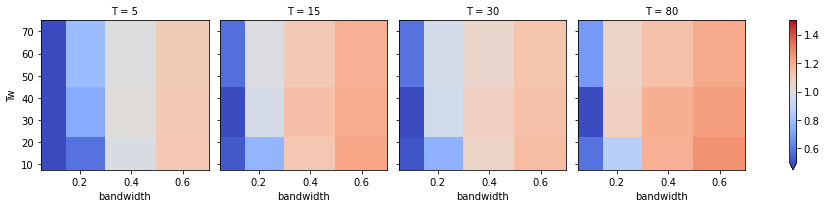

<Figure size 432x288 with 0 Axes>

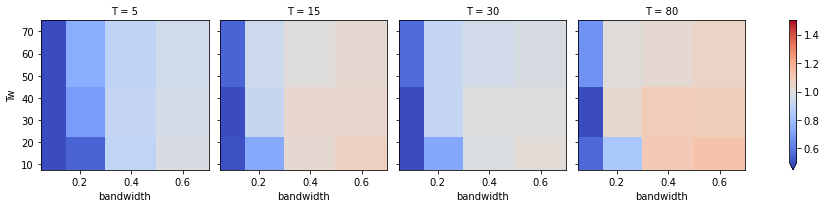

<Figure size 432x288 with 0 Axes>

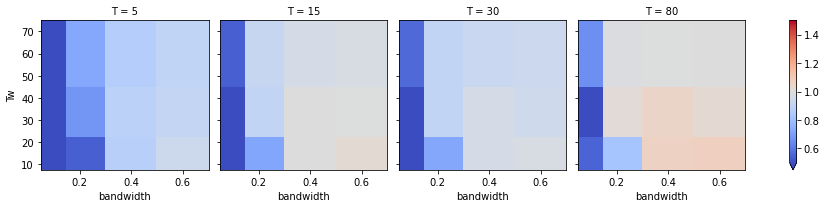

In [96]:
for U in Var.U_high:
    plt.figure()
    (Var.sel(T_low=30,U_high=U).total/(U**2)).plot(col='T',cmap='coolwarm',vmax=1.5,vmin=0.5)